<a target="_blank" href="https://colab.research.google.com/github/ashkan-mokarian/d2l-pytorch/blob/main/chapter_modern_cnn/4_batchnorm.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%pip install d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.6 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## Implementation from scratch

In [8]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # behave differently whether in training or inference
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # For FC layer
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            # For Conv layer
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)  # Care: Here use minibatch mean and var and not the moving ones, moving is kept for inference
        # In train mode, we use moving statistics and update with momentum
        moving_mean = (1.0 - momentum)*moving_mean + momentum*mean
        moving_var = (1.0 - momentum)*moving_var + momentum*var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [9]:
from traitlets.config.loader import ArgumentError
class BatchNorm(nn.Module):
    """Batch Normalization from scratch.

    Args:
        num_features: output dimension for FC layer, or channel dimension for Conv layer
        num_dims: 2 for FC, 4 for Conv
    """
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        elif num_dims == 4:
            shape = (1, num_features, 1, 1)
        else:
            raise ArgumentError('num_features can be either 2 or 4')
        # Parameters of the model that need to be learnt/trained
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # variables for book-keeping, not leanrt
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

        
    def forward(self, X):
        # We have to make sure that these variables are on the same device as
        # the model is on, or we would get an error, and since they are not 
        # parameters of the model, they are not automatically transfered accordingly
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, 1e-5, 0.1
        )
        return Y

Note that Batch Norm is used after Conv or FC layer, but before the consequent non-linearity. Remeber, None-linearity squashes or changes the inputs, so should not be included for batch norm.

In [10]:
# To showcase it for a simple LeNet model
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

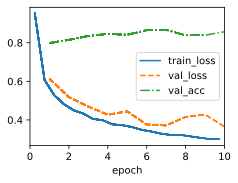

In [11]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Concise implementation
using nn.LazyBatchNorm2d() and nn.LazyBatchNorm1d()

In [ ]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))